#### Imports

In [276]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#import external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import math
%matplotlib inline

Check for CUDA

In [277]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal backend for Apple GPUs
else:
    device = torch.device("cpu")  # Fallback to CPU
print(device)

False
True
mps


In [278]:
! ls ../Data/
Data_folder_path = "../Data/"
train_df = pd.read_csv(Data_folder_path+"train.csv")
test_df = pd.read_csv(Data_folder_path+"test.csv")

sample_submission.csv test.csv              train.csv


#### Separate into labels and training images and reshape the images

In [279]:
train_labels = train_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_images = (test_df.iloc[:,:].values).astype('float32')

#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                     stratify=train_labels, random_state=123,
                                                                     test_size=0.20)

In [280]:
train_images = train_images.reshape(train_images.shape[0], 28, 28)
val_images = val_images.reshape(val_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)

#### Plot some images to see samples

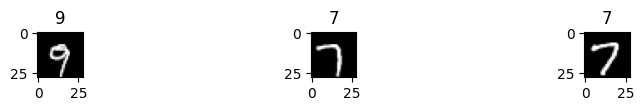

In [281]:
#train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

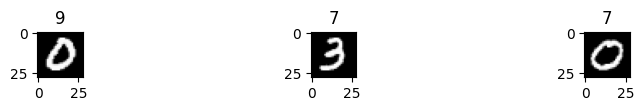

In [282]:
#test samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

#### Convert images to tensors
Normalize the images too

In [283]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

#test
test_images_tensor = torch.tensor(test_images)/255.0

#### Load images into the data generator

In [284]:
train_loader = DataLoader(train_tensor, batch_size=8, num_workers=0, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=8, num_workers=0, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=8, num_workers=0, shuffle=False)

#### Plot some sample images using the data generator

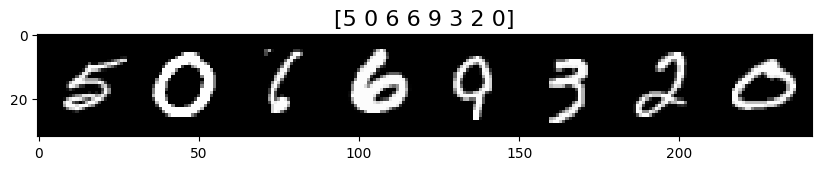

In [285]:
for batch_idx, (data, target) in enumerate(train_loader):
    img_grid = make_grid(data[0:8,].unsqueeze(1), nrow=8)
    img_target_labels = target[0:8,].numpy()
    break
    
plt.imshow(img_grid.numpy().transpose((1,2,0)))
plt.rcParams['figure.figsize'] = (10, 2)
plt.title(img_target_labels, size=16)
plt.show()

#### Define the CNN Model

In [286]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x
conv_model = Net()
conv_model

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

#### Define the optimizer and loss functions

In [287]:
optimizer = optim.Adam(params=conv_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

#### Training the Model

In [288]:
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

def train_and_validate(num_epochs, train_loader, val_loader):
    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")

        # Training phase
        conv_model.train()
        exp_lr_scheduler.step()
        
        total_train_loss = 0
        correct_train_predictions = 0
        total_train_samples = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.unsqueeze(1)  # Ensure correct input shape
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
            
            optimizer.zero_grad()
            output = conv_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            # Accumulate training loss
            total_train_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = output.max(1)
            correct_train_predictions += (predicted == target).sum().item()
            total_train_samples += target.size(0)
            
            if (batch_idx + 1) % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                    100. * (batch_idx + 1) / len(train_loader), loss.item()))
        
        # Calculate and record average training metrics for the epoch
        average_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train_predictions / total_train_samples
        training_losses.append(average_train_loss)
        training_accuracies.append(train_accuracy)

        # Validation phase
        conv_model.eval()
        total_val_loss = 0
        correct_val_predictions = 0
        total_val_samples = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data = data.unsqueeze(1)
                if torch.cuda.is_available():
                    data = data.cuda()
                    target = target.cuda()
                
                output = conv_model(data)
                loss = criterion(output, target)
                total_val_loss += loss.item()
                
                # Calculate validation accuracy
                _, predicted = output.max(1)
                correct_val_predictions += (predicted == target).sum().item()
                total_val_samples += target.size(0)
        
        # Calculate and record average validation metrics for the epoch
        average_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val_predictions / total_val_samples
        validation_losses.append(average_val_loss)
        validation_accuracies.append(val_accuracy)

        # Print metrics for the epoch
        print(f"Training - Loss: {average_train_loss:.4f}, Accuracy: {train_accuracy:.3f}")
        print(f"Validation - Loss: {average_val_loss:.4f}, Accuracy: {val_accuracy:.3f}\n")

# After training, plot the metrics
def plot_metrics():
    epochs = list(range(1, len(training_losses) + 1))
    
    # Plot losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_losses, linestyle='-', label='Training Loss')
    plt.plot(epochs, validation_losses, linestyle='-', label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.savefig("MNIST_CNN_loss.jpg", dpi = 1000)
    plt.show()
    
    # Plot accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_accuracies, linestyle='-', label='Training Accuracy')
    plt.plot(epochs, validation_accuracies, linestyle='-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig("MNIST_CNN_accuracy.jpg", dpi = 1000)
    plt.show()

Epoch 1/10


/Users/ginta/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train Epoch: 1 [800/33600 (2%)]	Loss: 1.344382
Train Epoch: 1 [1600/33600 (5%)]	Loss: 0.843471
Train Epoch: 1 [2400/33600 (7%)]	Loss: 0.658351
Train Epoch: 1 [3200/33600 (10%)]	Loss: 0.586030
Train Epoch: 1 [4000/33600 (12%)]	Loss: 0.856626
Train Epoch: 1 [4800/33600 (14%)]	Loss: 0.657706
Train Epoch: 1 [5600/33600 (17%)]	Loss: 1.078407
Train Epoch: 1 [6400/33600 (19%)]	Loss: 0.079987
Train Epoch: 1 [7200/33600 (21%)]	Loss: 0.896351
Train Epoch: 1 [8000/33600 (24%)]	Loss: 0.205939
Train Epoch: 1 [8800/33600 (26%)]	Loss: 0.423605
Train Epoch: 1 [9600/33600 (29%)]	Loss: 0.162722
Train Epoch: 1 [10400/33600 (31%)]	Loss: 0.441759
Train Epoch: 1 [11200/33600 (33%)]	Loss: 0.265490
Train Epoch: 1 [12000/33600 (36%)]	Loss: 0.281736
Train Epoch: 1 [12800/33600 (38%)]	Loss: 0.063991
Train Epoch: 1 [13600/33600 (40%)]	Loss: 0.515861
Train Epoch: 1 [14400/33600 (43%)]	Loss: 0.678849
Train Epoch: 1 [15200/33600 (45%)]	Loss: 0.313673
Train Epoch: 1 [16000/33600 (48%)]	Loss: 0.069957
Train Epoch: 1 [

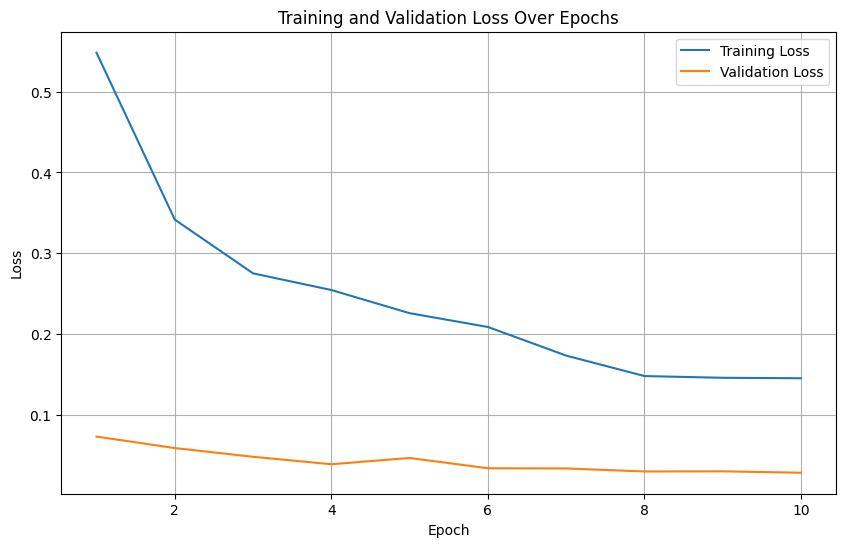

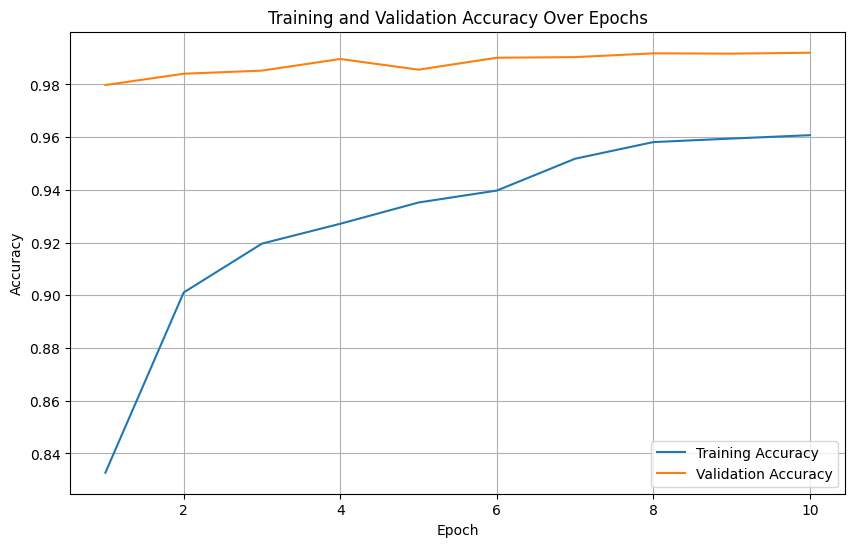

In [289]:
num_epochs = 10
train_and_validate(num_epochs, train_loader, val_loader)

# Plot the metrics after training
plot_metrics()

### Saving the full CNN model

In [ ]:
# Save the full model
torch.save(conv_model, 'cnn_full_model.pth')

### Loading the full CNN model

In [30]:
# To load the full model after the JN has timed out:
conv_model = torch.load('cnn_full_model.pth')
if torch.cuda.is_available():
    conv_model = conv_model.cuda()
conv_model.eval()  # Setting the model to evaluation mode

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
  

#### Make predictions on the test set (just the CNN)

In [31]:
def make_predictions(data_loader):
    conv_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = conv_model(data)
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

#Run the inference
test_set_preds = make_predictions(test_loader)

#### Prepare Submissions

In [28]:
submission_df = pd.read_csv("../Data/sample_submission.csv")

In [29]:
submission_df['Label'] = test_set_preds.numpy().squeeze()
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [30]:
submission_df.to_csv('submission.csv', index=False)

### Puppeteer MLP

In [35]:
class PuppeteerNet(nn.Module):
    def __init__(self):
        super(PuppeteerNet, self).__init__()
        
        # Input: 10 neurons (one-hot encoded digit to inhibit)
        # Output: 6272 (to match CNN's 128*7*7 feature map)
        
        self.mlp = nn.Sequential(
            # First layer
            nn.Linear(10, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            # Second layer
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            # Third layer
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            # Fourth layer
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            # Fifth layer
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            # Output layer
            nn.Linear(512, 128*7*7),  # 6272 outputs to match CNN's feature map
            nn.Tanh()  # Allow for positive and negative manipulation
        )
        
    def forward(self, x):
        return self.mlp(x)
    
puppeteer_net=PuppeteerNet()
puppeteer_net

PuppeteerNet(
  (mlp): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.3)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): Dropout(p=0.3)
    (8): Linear(in_features=1024, out_features=2048, bias=True)
    (9): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Dropout(p=0.3)
    (12): Linear(in_features=2048, out_features=1024, bias=True)
    (13): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace)
    (15): Dropout(p=0.3)
    (16): Linear(in_features=1024, out_features=512, bias=True)
    (17): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [41]:
print(images.shape)


torch.Size([8, 1, 28, 28])


In [44]:
# Freeze CNN parameters
for param in conv_model.parameters():
    param.requires_grad = False

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    puppeteer_net = puppeteer_net.cuda()

# Define optimizer for the Puppeteer MLP
optimizer = optim.Adam(puppeteer_net.parameters(), lr=0.001)

# Training loop parameters
num_epochs = 10

for epoch in range(num_epochs):
    puppeteer_net.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.unsqueeze(1)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        batch_size = images.size(0)
        
        # Select digits to inhibit (using true labels for simplicity)
        inhibited_digits = labels  # Alternatively, use random digits to inhibit
        
        # Convert inhibited digits to one-hot vectors
        inhibited_digits_one_hot = torch.zeros(batch_size, 10).to(images.device)
        inhibited_digits_one_hot.scatter_(1, inhibited_digits.view(-1, 1), 1)
        
        # Forward pass through conv_block of the CNN
        x = conv_model.conv_block(images)
        
        # Flatten the activations
        x = x.view(batch_size, -1)
        
        # Get adjustments from Puppeteer MLP
        adjustments = puppeteer_net(inhibited_digits_one_hot)
        
        # Adjust the activations
        x = x + adjustments  # You can experiment with other operations like multiplication
        
        # Pass adjusted activations through linear_block of the CNN
        output = conv_model.linear_block(x)
        
        # Compute softmax probabilities
        output_probs = F.softmax(output, dim=1)
        
        # Probability of predicting the inhibited digit
        p_inhibited = output_probs[range(batch_size), inhibited_digits]
        
        # Loss function to penalize high probability of inhibited digit
        epsilon = 1e-6  # Small value to prevent log(0)
        loss = -torch.log(1 - p_inhibited + epsilon)
        loss = torch.mean(loss)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print training progress
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0


Epoch [1/10], Step [100/4200], Loss: 1.1831
Epoch [1/10], Step [200/4200], Loss: 0.0205
Epoch [1/10], Step [300/4200], Loss: 0.0114
Epoch [1/10], Step [400/4200], Loss: 0.0135
Epoch [1/10], Step [500/4200], Loss: 0.0226
Epoch [1/10], Step [600/4200], Loss: 0.0107
Epoch [1/10], Step [700/4200], Loss: 0.0117
Epoch [1/10], Step [800/4200], Loss: 0.0049
Epoch [1/10], Step [900/4200], Loss: 0.0062
Epoch [1/10], Step [1000/4200], Loss: 0.0048
Epoch [1/10], Step [1100/4200], Loss: 0.0081
Epoch [1/10], Step [1200/4200], Loss: 0.0058
Epoch [1/10], Step [1300/4200], Loss: 0.0052
Epoch [1/10], Step [1400/4200], Loss: 0.0027
Epoch [1/10], Step [1500/4200], Loss: 0.0028
Epoch [1/10], Step [1600/4200], Loss: 0.0033
Epoch [1/10], Step [1700/4200], Loss: 0.0055
Epoch [1/10], Step [1800/4200], Loss: 0.0033
Epoch [1/10], Step [1900/4200], Loss: 0.0009
Epoch [1/10], Step [2000/4200], Loss: 0.0027
Epoch [1/10], Step [2100/4200], Loss: 0.0035
Epoch [1/10], Step [2200/4200], Loss: 0.0059
Epoch [1/10], Step 